<a href="https://colab.research.google.com/github/moveformyfuture/LG_Prediction_of_Antenna_performance/blob/main/GMM_KMEANS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import Libraries

In [1]:
import pandas as pd
import random
import os
import numpy as np
import time
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
from functools import partial
from lightgbm import LGBMRegressor
from hyperopt import fmin, hp, tpe
from hyperopt.pyll.base import scope
from hyperopt.pyll.stochastic import sample
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import statsmodels.formula.api as sm
from statsmodels.api import add_constant
import statsmodels.api as sm

from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(42) # Seed 고정

### Usable Functions 

In [3]:
def dataset_split_X_y(df):    
    """
    @Description: split data into features and labels
    @Param: df, pandas dataframe with columns starting with X for features and Y for labels
    @Return: features and labels in pandas dataframes
    """
    xs = df.filter(regex='X') # Input : X Feature
    ys = df.filter(regex='Y') # Output : Y Feature
    return xs, ys

In [4]:
def check_for_NAs(df, show=False):
    """
    @Description: checks for the NAs in the dataframe
    @Param1: df, pandas dataframe
    @Param2: show, boolean indicating whether NaN data are also necessary as a part of the output
    @Return: name of the columns with NaN
    """
    nan_values = df.loc[:, df.isnull().any()]
    if show:
        return df[df.isna().any(axis=1)]
    return list(nan_values.columns)

In [5]:
def check_for_label_bound(df, labels, bound):
    """
    @Description: check bound is inbetween min and max
    @Param1: df, pandas dataframe
    @Param2: labels, list of column names 
    @Param3: thres: list of bounds
    @Return: names of the columns not within the bound
    """
    n = len(labels)
    result = []
    for idx in range(n):
        col = labels[idx]
        thres = bound[idx]
        extracted_column = df[col]
        if not extracted_column.between(thres[0], thres[1]).all():
            result.append(labels[idx])
    if len(result) == 0:
        print('everything is within the bound')
    return result

In [6]:
def zero_variance(df):
    """
    @Description: check for zero_variance
    @Param1: df, pandas dataframe
    @Return: names of the columns with zero variance
    """
    result = []
    for col in df.columns:
        if df[col].var() == 0:
            result.append(col)
    return result

In [7]:
def get_top_correlation(df, n=10):
    """
    @Description: print out top correlated features
    @Param1: df, pandas dataframe
    @Param2: n, number of lines to print 
    @Return: pandas series
    """
    pairs = set()
    for idx1 in range(0, df.shape[1]):
        for idx2 in range(0, idx1+1):
            pairs.add((df.columns[idx1], df.columns[idx2]))
    corr = df.corr().abs().unstack()
    corr = corr.drop(labels=pairs).sort_values(ascending=False)
    return corr[0:n]

In [8]:
def adjacent_histogram_boxplot(feature_var, figsize = (7, 5)):
    """
    @Description: plot histogram and boxplot in next to each other
    @Param1: feature_var, pandas series 
    @Param2: figsize, size of the figure 
    """
    fig, (hist_plot, box_plot) = plt.subplots(nrows=2, sharex=True, gridspec_kw={'height_ratios':(.85,.15)}, figsize=figsize)
    sns.distplot(feature_var, kde=True, ax=hist_plot, kde_kws= {"linewidth":1.5}) 
    sns.boxplot(feature_var, ax=box_plot, linewidth = 1, width = 0.5)
    hist_plot.set_ylabel('')    
    hist_plot.set_xlabel('')
    box_plot.set_xlabel('')
    hist_plot.tick_params(labelsize=8)
    box_plot.tick_params(labelsize=8)
    fig.suptitle(feature_var.name, fontsize = 10)
    hist_plot.axvline(np.mean(feature_var),color='red',linestyle='-',lw = 1.5)
    hist_plot.axvline(np.median(feature_var),color='green',linestyle='--',lw = 1.5)
    

In [9]:
def lg_nrmse(gt, preds):
    """
    @Description: Metric used in this project
    @Params1: gt, pandas dataframe
    @Param2: preds, pandas dataframe
    @Return: nrmse score
    """
    # 각 Y Feature별 NRMSE 총합
    # Y_01 ~ Y_08 까지 20% 가중치 부여
    preds = pd.DataFrame(preds)
    all_nrmse = []
    for idx in range(0,14):
        rmse = mean_squared_error(gt.iloc[:,idx], preds.iloc[:,idx], squared=False)
        nrmse = rmse/np.mean(np.abs(gt.iloc[:,idx]))
        all_nrmse.append(nrmse)
    score = 1.2 * np.sum(all_nrmse[:8]) + 1.0 * np.sum(all_nrmse[8:15])
    return score

In [10]:
def dataset_split_X_y(df):    
    """
    @Description: split data into features and labels
    @Param: df, pandas dataframe with columns starting with X for features and Y for labels
    @Return: features and labels in pandas dataframes
    """
    xs = df.filter(regex='X') # Input : X Feature
    ys = df.filter(regex='Y') # Output : Y Feature
    return xs, ys

In [11]:
# 구글 드라이브에 접근할 수 있도록 아래 코드 입력
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
# 데이터셋 설정
train_df = pd.read_csv('/content/drive/MyDrive/AI 프로젝트 자료/LG 자율주행 센서의 안테나 성능 예측/data/train.csv')
test_x = pd.read_csv('/content/drive/MyDrive/AI 프로젝트 자료/LG 자율주행 센서의 안테나 성능 예측/data/test.csv')

In [13]:
#train data 분리
train_x, train_y = dataset_split_X_y(train_df)
#train_x 에서 분산이 0인 data 추출
cols_with_zero_variance = zero_variance(train_x)
#train_x에서 분산이 0인 데이터 제거
train_x = train_x.drop(cols_with_zero_variance, axis = 1)
#test_x에서 분산이 0인 데이터 제거
test_x = test_x.drop(cols_with_zero_variance, axis = 1)

ys = ['Y_01', 'Y_02', 'Y_03', 'Y_04', 'Y_05', 
      'Y_06', 'Y_07', 'Y_08', 'Y_09', 'Y_10', 
      'Y_11', 'Y_12', 'Y_13', 'Y_14']
ys_bounds = [[0.2, 2], [0.2, 2.1], [0.2, 2.1], 
             [7, 19], [22, 36.5], [-19.2, 19], 
             [2.4, 4], [-29.2, -24], [-29.2, -24],
             [-30.6, -20], [19.6, 26.6], [-29.2, -24],
             [-29.2, -24], [-29.2, -24]]

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

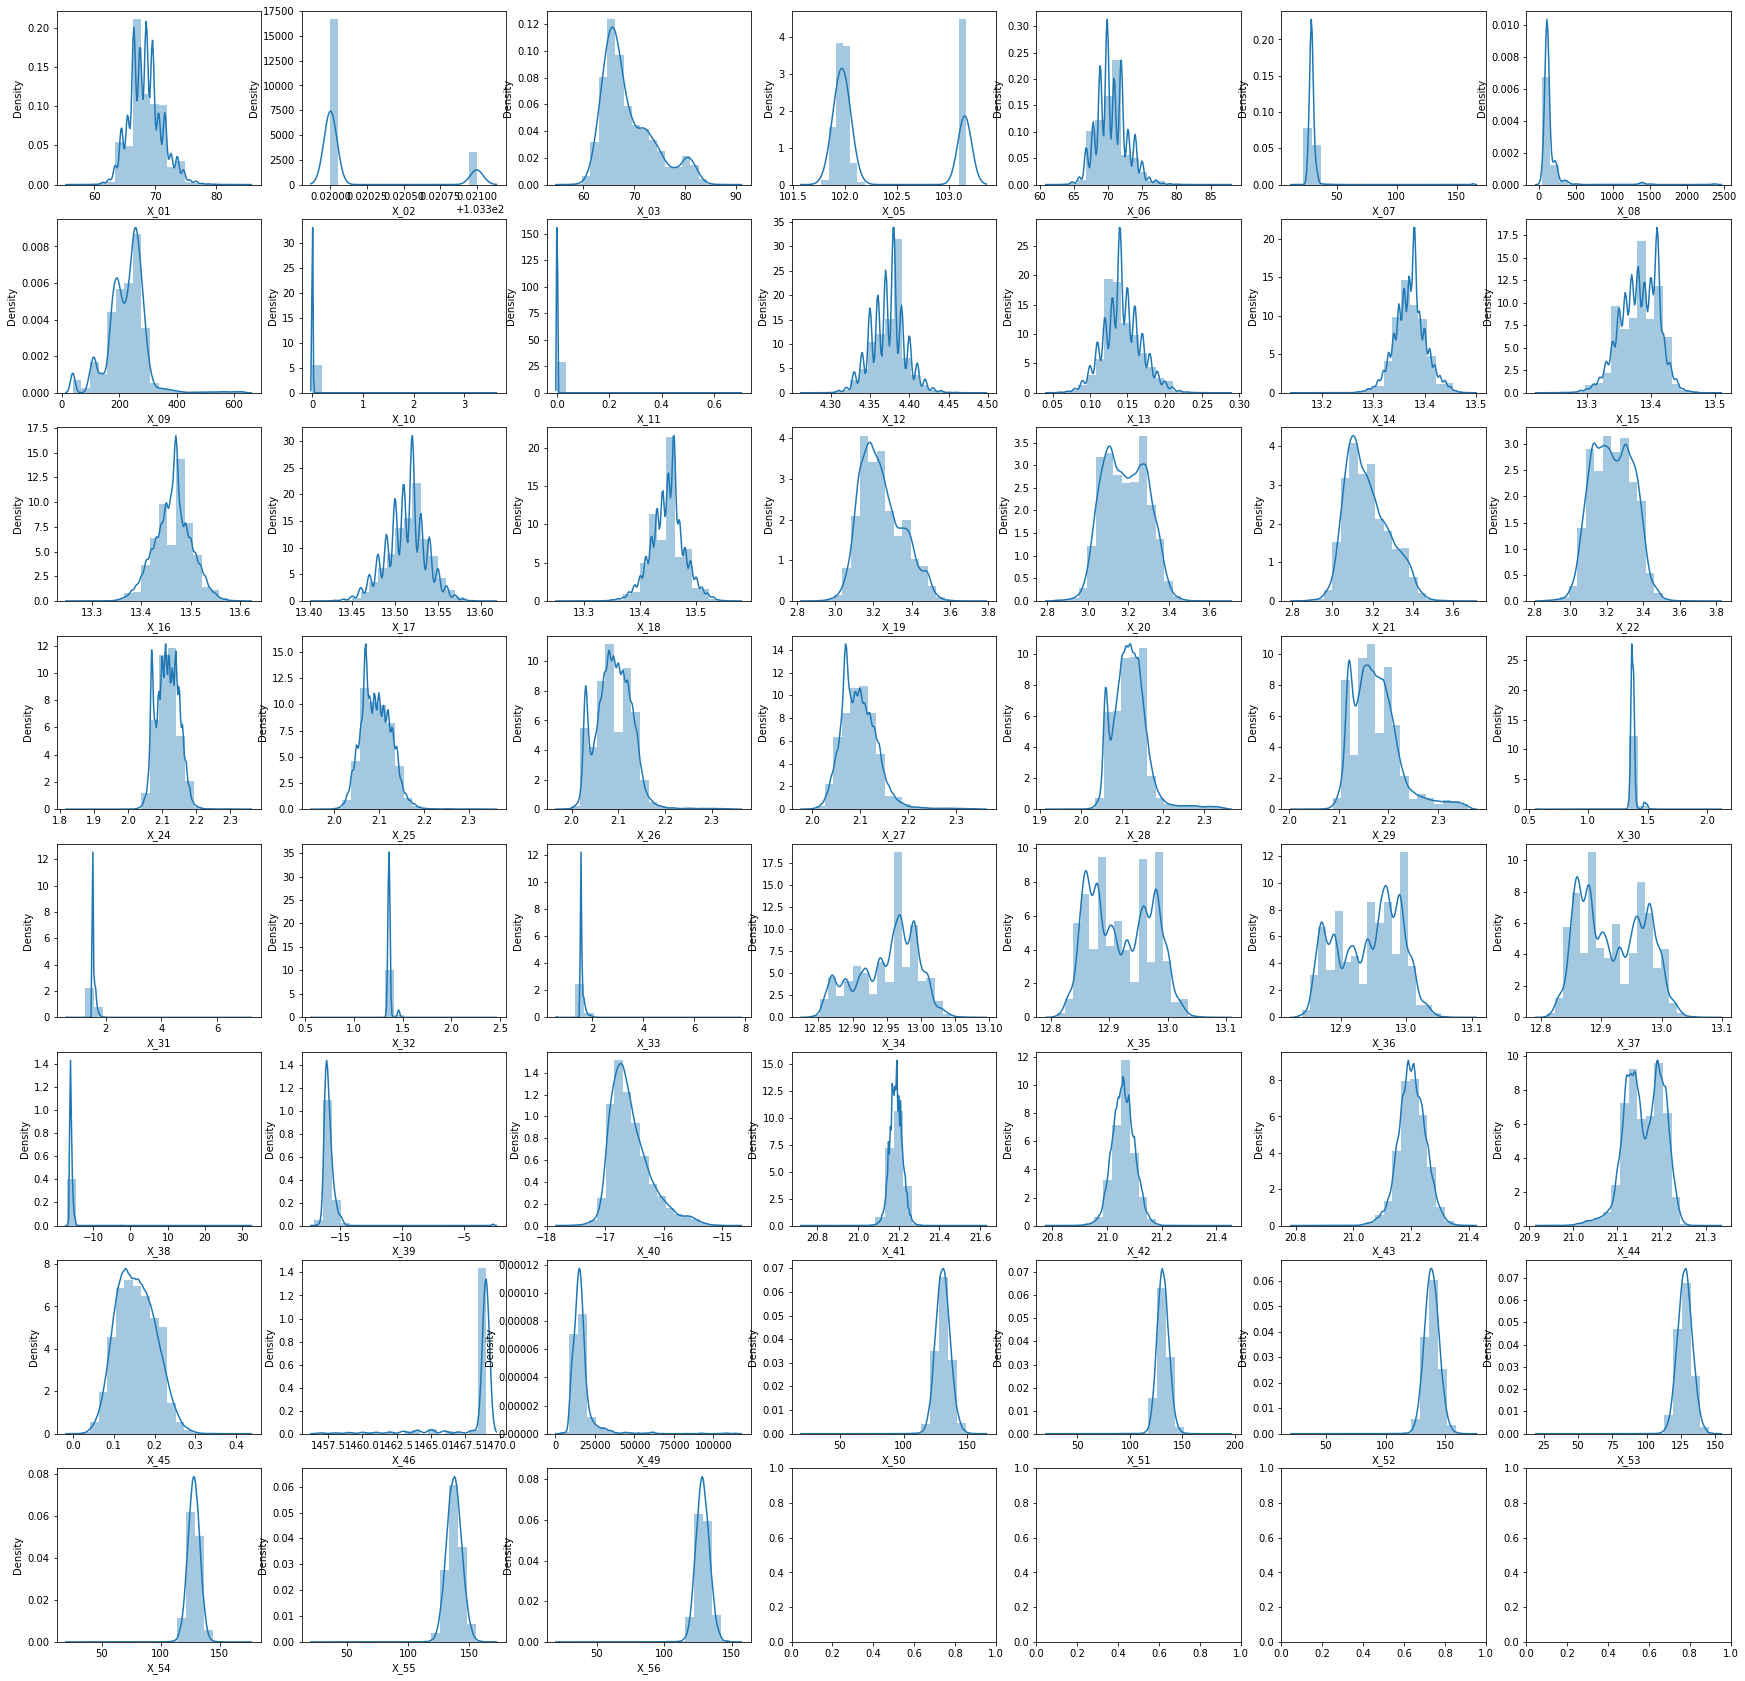

In [14]:
# 모든 X 변수에 대해 그래프 그리기
col_n=7
fig, ax = plt.subplots(8, 7, figsize=(30,30))

for i,col in enumerate(train_x[:]) :
    sns.distplot(train_x[col], bins=20, ax=ax[int(i/col_n),int(i%col_n)])

In [15]:
# 다봉 의심 : X_03, X_05, X_15, X_18, X_22, X_34, X_35, X_36, X_37, X_44
X_03_1, X_03_2

행 개수가 달라짐 -> 데이터 불균형으로 학습이 안될것 data 불균형 극복
test

gage R&R
재현성과 반복성
다른 설비로 했을대, 다른 operator가 설비를 사용할대 같은 결과가 나와야 한다.
사람의 숙련도 차이

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  import sys


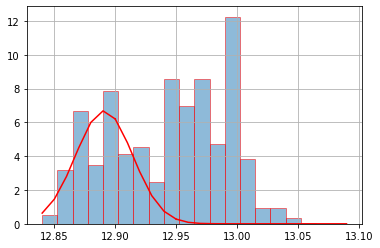

In [16]:
# GMM Test
from sklearn.mixture import GaussianMixture

# GMM: n_components = 모델의 총 수

# reshape
f=np.ravel(train_x['X_36']).astype(np.float)
f=f.reshape(-1,1)

# model 선언
g = GaussianMixture(n_components=2,covariance_type='full')
g.fit(f)
weights = g.weights_
means = g.means_
covars = g.covariances_

# 시각화
plt.hist(f, bins=20, histtype='bar', density=True, ec='red', alpha=0.5)

f_axis = f.copy().ravel()
f_axis.sort()
plt.plot(f_axis,weights[0]*stats.norm.pdf(f_axis,means[0],np.sqrt(covars[0])).ravel(), c='red')

plt.rcParams['agg.path.chunksize'] = 10000

plt.grid()
plt.show()

In [23]:
a=pd.DataFrame(f_axis)
a.describe()

,0
count,39607.000000
mean,12.941728
std,0.047830
min,12.840000
25%,12.900000
50%,12.950000
75%,12.980000
max,13.090000


In [17]:
from sklearn.kmeans_label import KMeans

k=np.ravel(train_x['X_36']).astype(np.float)
k=k.reshape(-1,1)

# KMeans
kmeans = KMeans(n_kmeans_labels=2)
kmeans_label = kmeans.fit_predict(k)

# 군집 레이블 추가
train_x["kmeans_label"] = kmeans_label

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until


In [35]:
# kmeans_label과 X_36 시각화
# kmeans_label 값이 0, 1, 2 인 경우마다 별도의 Index로 추출
marker0_ind = train_x[train_x['kmeans_label']==0].index
marker1_ind = train_x[train_x['kmeans_label']==1].index

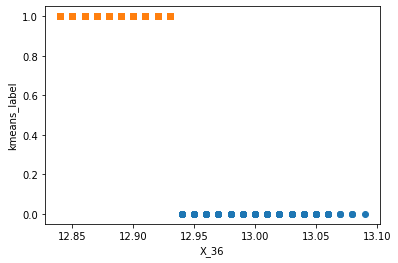

In [38]:
# cluster값 0, 1, 2에 해당하는 Index로 각 cluster 레벨의 X_36, kmeans_label 값 추출. o, s 로 marker 표시
plt.scatter(x=train_x.loc[marker0_ind,'X_36'], y=train_x.loc[marker0_ind,'kmeans_label'], marker='o') 
plt.scatter(x=train_x.loc[marker1_ind,'X_36'], y=train_x.loc[marker1_ind,'kmeans_label'], marker='s')
plt.xlabel('X_36')
plt.ylabel('kmeans_label')
plt.show()